In [1]:
# 2. Imports
import os
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.nasnet import NASNetMobile, preprocess_input
from tensorflow.keras import layers, models, optimizers, callbacks
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
# 3. Paths & Parameters
BASE_DIR = '/content/drive/MyDrive/wrist_xray_NASNetMobile'
train_dir = os.path.join(BASE_DIR, 'train')
val_dir = os.path.join(BASE_DIR, 'val')

IMG_SIZE = (224, 224)  # NASNetMobile input size
BATCH_SIZE = 64  # Larger batch size due to mobile architecture
VAL_SPLIT = 0.2
SEED = 42


In [3]:
# 4. Create train/val folders
for split_dir in [train_dir, val_dir]:
    for cls in ['Normal', 'Fracture']:
        os.makedirs(os.path.join(split_dir, cls), exist_ok=True)


In [4]:
# 5. Split & copy images
for cls in ['Normal', 'Fracture']:
    src = os.path.join(BASE_DIR, cls)
    imgs = [f for f in os.listdir(src) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    train_imgs, val_imgs = train_test_split(imgs, test_size=VAL_SPLIT, random_state=SEED)

    for fname in train_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(train_dir, cls, fname))
    for fname in val_imgs:
        shutil.copy(os.path.join(src, fname), os.path.join(val_dir, cls, fname))
print("✅ Dataset split into train/val folders")

✅ Dataset split into train/val folders


In [5]:
# 6. Data Generators & Augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.1,
    zoom_range=0.2,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=SEED
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

Found 153 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [6]:
# 7. Compute Class Weights
counts = Counter(train_gen.classes)
total = sum(counts.values())
class_weight = {k: total/(2*v) for k,v in counts.items()}
print("Class weights:", class_weight)

Class weights: {np.int32(0): 0.8693181818181818, np.int32(1): 1.176923076923077}


In [7]:
# 8. Build NASNetMobile Model
def build_model():
    base_model = NASNetMobile(
        weights='imagenet',
        include_top=False,
        input_shape=(*IMG_SIZE, 3)
    )
    base_model.trainable = False

    inputs = layers.Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.6)(x)  # Higher dropout for mobile architecture
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1056)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       135,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,405,141 (16.80 MB)

 Trainable params: 135,425 (529.00 KB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [8]:
# 9. Compile & Callbacks
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

callbacks = [
    callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    callbacks.ModelCheckpoint('best_nasnetmobile.h5', save_best_only=True),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]


In [9]:
# 10. Train Head
history_head = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    class_weight=class_weight,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.4746 - loss: 0.9048 - precision: 0.4182 - recall: 0.4145   

3/3 ━━━━━━━━━━━━━━━━━━━━ 72s 17s/step - accuracy: 0.4736 - loss: 0.9094 - precision: 0.4136 - recall: 0.4339 - val_accuracy: 0.5250 - val_loss: 0.7133 - val_precision: 0.4722 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5529 - loss: 0.7799 - precision: 0.5296 - recall: 0.7124

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5618 - loss: 0.7638 - precision: 0.5251 - recall: 0.7035 - val_accuracy: 0.7750 - val_loss: 0.5070 - val_precision: 0.7500 - val_recall: 0.7059 - learning_rate: 0.0010
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 698ms/step - accuracy: 0.6203 - loss: 0.6584 - precision: 0.5541 - recall: 0.5112

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6286 - loss: 0.6565 - precision: 0.5664 - recall: 0.5180 - val_accuracy: 0.8000 - val_loss: 0.4669 - val_precision: 0.8000 - val_recall: 0.7059 - learning_rate: 0.0010
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7541 - loss: 0.4999 - precision: 0.6669 - recall: 0.6720

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7486 - loss: 0.5160 - precision: 0.6808 - recall: 0.6540 - val_accuracy: 0.8000 - val_loss: 0.4543 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 0.0010
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 954ms/step - accuracy: 0.7090 - loss: 0.6541 - precision: 0.6591 - recall: 0.6627 - val_accuracy: 0.8250 - val_loss: 0.4960 - val_precision: 0.7083 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 847ms/step - accuracy: 0.7396 - loss: 0.5276 - precision: 0.6289 - recall: 0.8946 - val_accuracy: 0.8250 - val_loss: 0.4674 - val_precision: 0.7083 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 697ms/step - accuracy: 0.7683 - loss: 0.4997 - precision: 0.7046 - recall: 0.8151

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.7658 - loss: 0.5013 - precision: 0.6972 - recall: 0.8190 - val_accuracy: 0.8000 - val_loss: 0.4500 - val_precision: 0.6957 - val_recall: 0.9412 - learning_rate: 3.0000e-04
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 755ms/step - accuracy: 0.6759 - loss: 0.5399 - precision: 0.5557 - recall: 0.7093

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.6801 - loss: 0.5375 - precision: 0.5722 - recall: 0.7089 - val_accuracy: 0.8250 - val_loss: 0.4276 - val_precision: 0.7500 - val_recall: 0.8824 - learning_rate: 3.0000e-04
Epoch 9/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 704ms/step - accuracy: 0.6960 - loss: 0.5058 - precision: 0.6147 - recall: 0.7106

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.6968 - loss: 0.5130 - precision: 0.6204 - recall: 0.7022 - val_accuracy: 0.8000 - val_loss: 0.4159 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 3.0000e-04
Epoch 10/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8058 - loss: 0.5027 - precision: 0.8112 - recall: 0.7057

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8021 - loss: 0.4948 - precision: 0.8010 - recall: 0.7100 - val_accuracy: 0.8000 - val_loss: 0.4125 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 3.0000e-04
Epoch 11/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 989ms/step - accuracy: 0.7771 - loss: 0.5012 - precision: 0.7356 - recall: 0.6665

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7855 - loss: 0.4926 - precision: 0.7571 - recall: 0.6768 - val_accuracy: 0.8000 - val_loss: 0.4114 - val_precision: 0.7368 - val_recall: 0.8235 - learning_rate: 3.0000e-04
Epoch 12/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 836ms/step - accuracy: 0.7515 - loss: 0.5225 - precision: 0.7075 - recall: 0.7319 - val_accuracy: 0.8500 - val_loss: 0.4138 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 3.0000e-04
Epoch 13/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7938 - loss: 0.4603 - precision: 0.7818 - recall: 0.7699 - val_accuracy: 0.8500 - val_loss: 0.4201 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 3.0000e-04
Epoch 14/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 826ms/step - accuracy: 0.7658 - loss: 0.4844 - precision: 0.7609 - recall: 0.6914 - val_accuracy: 0.8500 - val_loss: 0.4229 - val_precision: 0.7619 - val_recall: 0.9412 - learning_rate: 9.0000e-05
Epoch 15/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - accuracy: 0.8281 - l

In [10]:
# 11. Fine-Tuning Phase
# Unfreeze last 40% of layers
model.trainable = True
total_layers = len(model.layers[1].layers)
unfreeze_from = int(0.6 * total_layers)

for layer in model.layers[1].layers[:unfreeze_from]:
    layer.trainable = False
for layer in model.layers[1].layers[unfreeze_from:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False  # Keep BN layers frozen
    else:
        layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    initial_epoch=history_head.epoch[-1],
    class_weight=class_weight,
    callbacks=callbacks
)

Epoch 17/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7180 - loss: 0.5523  

3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 19s/step - accuracy: 0.7215 - loss: 0.5472 - val_accuracy: 0.8250 - val_loss: 0.4044 - learning_rate: 1.0000e-05
Epoch 18/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 817ms/step - accuracy: 0.7342 - loss: 0.5124 - val_accuracy: 0.8500 - val_loss: 0.4066 - learning_rate: 1.0000e-05
Epoch 19/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7366 - loss: 0.5005 - val_accuracy: 0.8500 - val_loss: 0.4064 - learning_rate: 1.0000e-05
Epoch 20/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.8184 - loss: 0.4171

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.8213 - loss: 0.4157 - val_accuracy: 0.8500 - val_loss: 0.4034 - learning_rate: 3.0000e-06
Epoch 21/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8027 - loss: 0.5149

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8047 - loss: 0.5008 - val_accuracy: 0.8500 - val_loss: 0.3982 - learning_rate: 3.0000e-06
Epoch 22/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 670ms/step - accuracy: 0.8692 - loss: 0.4352

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8643 - loss: 0.4382 - val_accuracy: 0.8500 - val_loss: 0.3920 - learning_rate: 3.0000e-06
Epoch 23/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 685ms/step - accuracy: 0.7757 - loss: 0.4600

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7730 - loss: 0.4630 - val_accuracy: 0.8500 - val_loss: 0.3850 - learning_rate: 3.0000e-06
Epoch 24/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 908ms/step - accuracy: 0.7803 - loss: 0.4104

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7813 - loss: 0.4106 - val_accuracy: 0.8500 - val_loss: 0.3798 - learning_rate: 3.0000e-06
Epoch 25/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.7727 - loss: 0.4800

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7723 - loss: 0.4809 - val_accuracy: 0.8500 - val_loss: 0.3755 - learning_rate: 3.0000e-06
Epoch 26/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.8227 - loss: 0.3837

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.8180 - loss: 0.3897 - val_accuracy: 0.8500 - val_loss: 0.3728 - learning_rate: 3.0000e-06
Epoch 27/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7977 - loss: 0.4337

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.7927 - loss: 0.4477 - val_accuracy: 0.8500 - val_loss: 0.3703 - learning_rate: 3.0000e-06
Epoch 28/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7816 - loss: 0.4307

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7757 - loss: 0.4330 - val_accuracy: 0.8500 - val_loss: 0.3693 - learning_rate: 3.0000e-06
Epoch 29/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7722 - loss: 0.4564

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7785 - loss: 0.4594 - val_accuracy: 0.8500 - val_loss: 0.3687 - learning_rate: 3.0000e-06
Epoch 30/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.7721 - loss: 0.4899 - val_accuracy: 0.8500 - val_loss: 0.3688 - learning_rate: 3.0000e-06


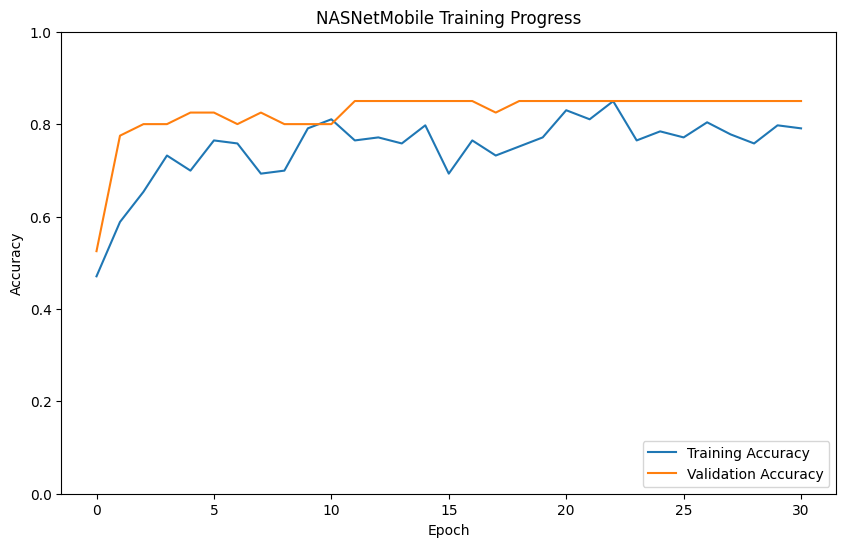

In [11]:
# 12. Version-safe Plotting
def plot_history(histories):
    key_mapping = {
        'train_acc': ['accuracy', 'acc'],
        'val_acc': ['val_accuracy', 'val_acc']
    }

    train_acc = []
    for hist in histories:
        for key in key_mapping['train_acc']:
            if key in hist.history:
                train_acc += hist.history[key]
                break

    val_acc = []
    for hist in histories:
        for key in key_mapping['val_acc']:
            if key in hist.history:
                val_acc += hist.history[key]
                break

    plt.figure(figsize=(10, 6))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')
    plt.title('NASNetMobile Training Progress')
    plt.show()

plot_history([history_head, history_fine])


In [12]:
# 13. Evaluation & Saving
model.load_weights('best_nasnetmobile.h5')
loss, acc = model.evaluate(val_gen)
print(f"\n✅ Final Validation Accuracy: {acc*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.8500 - loss: 0.3687

✅ Final Validation Accuracy: 85.00%


In [13]:
# 14. Save Model
model.save("/content/drive/MyDrive/nasnetmobile_wrist_model.h5")

In [14]:
# 15. Prediction Function
def predict_single_image(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = 'Fracture' if prediction < 0.5 else 'Normal'

    plt.imshow(img)
    plt.title(f"NASNetMobile Prediction: {label} ({prediction:.4f})")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step


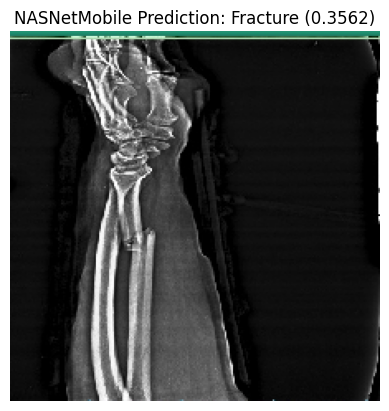

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


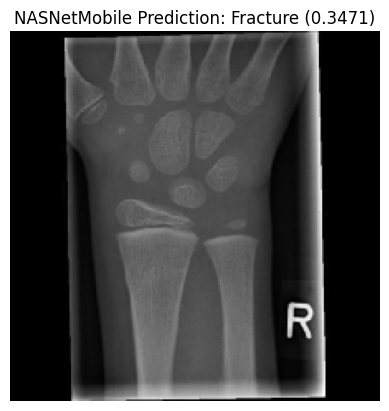

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


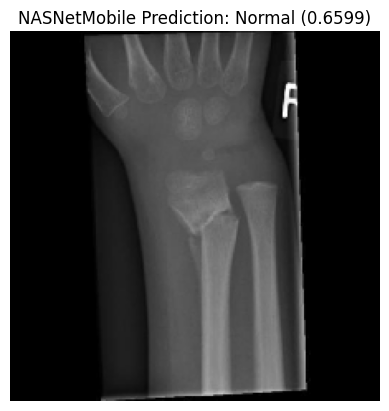

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


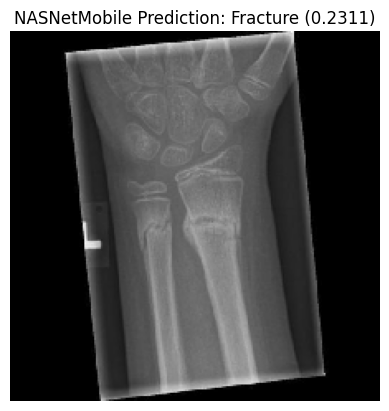

In [15]:
# Test prediction
predict_single_image('/content/drive/MyDrive/wrist_xray_NASNetMobile/Fracture/3 Male (L View).jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_NASNetMobile/196.jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_NASNetMobile/288.jpg')
predict_single_image('/content/drive/MyDrive/wrist_xray_NASNetMobile/346.jpg')
